In [1]:
import numpy as np
import pandas as pd 
import pandas as pd
import gensim
import gensim.corpora as corpora
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
import re
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import FreqDist
import spacy
import en_core_web_sm

## 1. EDA

### 1.1 Train Data

In [2]:
with open('train.txt', 'r', encoding='utf-8') as f:
    train = f.readlines()
    
train = [w.strip().split() for w in train]

In [3]:
# train txt contains 66125 lines
len(train)

66125

In [4]:
# train txt contrains 14879 unique words
words = list(set([w[0] for w in train if len(w)!=0]))
words.append("endpad")
n_words = len(words)
n_words

14879

In [5]:
# train txt contrains 13 tags
tags = list(set([w[1] for w in train if len(w)!=0]))
n_tags = len(tags)
n_tags

13

In [6]:
tags

['B-corporation',
 'B-person',
 'I-creative-work',
 'B-location',
 'O',
 'B-group',
 'B-creative-work',
 'B-product',
 'I-person',
 'I-corporation',
 'I-location',
 'I-group',
 'I-product']

In [7]:
train_df = pd.DataFrame(train)
train_df.columns = ["word", "tag"]
train_df = train_df[train_df['word'].notna()]

[Text(0, 0, 'O'),
 Text(0, 0, 'B-location'),
 Text(0, 0, 'I-location'),
 Text(0, 0, 'B-group'),
 Text(0, 0, 'B-corporation'),
 Text(0, 0, 'B-person'),
 Text(0, 0, 'B-creative-work'),
 Text(0, 0, 'B-product'),
 Text(0, 0, 'I-person'),
 Text(0, 0, 'I-creative-work'),
 Text(0, 0, 'I-corporation'),
 Text(0, 0, 'I-group'),
 Text(0, 0, 'I-product')]

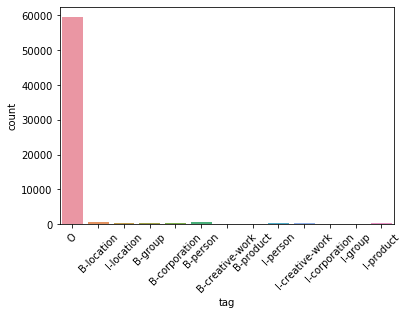

In [14]:
import seaborn as sns

plt1 = sns.countplot(x='tag',data = train_df)
plt1.set_xticklabels(plt1.get_xticklabels(), rotation=45)

[Text(0, 0, 'B-location'),
 Text(0, 0, 'I-location'),
 Text(0, 0, 'B-group'),
 Text(0, 0, 'B-corporation'),
 Text(0, 0, 'B-person'),
 Text(0, 0, 'B-creative-work'),
 Text(0, 0, 'B-product'),
 Text(0, 0, 'I-person'),
 Text(0, 0, 'I-creative-work'),
 Text(0, 0, 'I-corporation'),
 Text(0, 0, 'I-group'),
 Text(0, 0, 'I-product')]

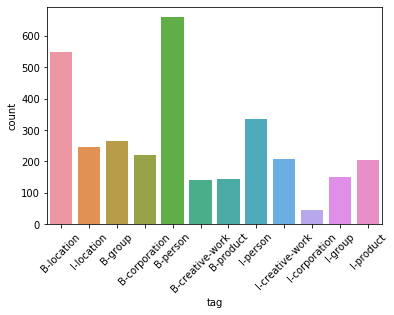

In [9]:
# more tags are about location and person
train_df_1 = train_df[train_df['tag'] != 'O']

plt2 = sns.countplot(x='tag',data = train_df_1)
plt2.set_xticklabels(plt2.get_xticklabels(), rotation=45)

In [10]:
train_sentences = []
train_temp = []
for w in train:
    if len(w) != 0:
        train_temp.append((w[0], w[1]))
    else:
        train_sentences.append(train_temp)
        train_temp = []

In [11]:
# train txt contrains 3395 sentences
len(train_sentences)

3395

In [12]:
# the max length of sentence is 41
maxlen = max([len(s) for s in train_sentences])
print ('Maximum sequence length:', maxlen)

Maximum sequence length: 41


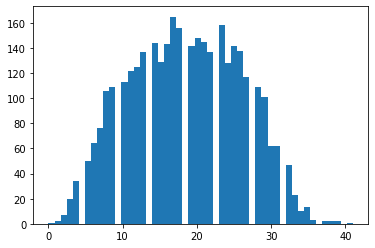

In [13]:
# the distribution of sentence length are similar to Gaussian distribution
import matplotlib.pyplot as plt

plt.hist([len(s) for s in train_sentences], bins=50)
plt.show()

### 1.2 Test Data

In [15]:
with open('test.txt', 'r', encoding='utf-8') as f:
    test = f.readlines()
    
test = [w.strip().split() for w in test]

In [16]:
# test txt contains 24681 lines
len(test)

24681

In [17]:
# test txt contains 6348 unique words
test_df = pd.DataFrame(test)
test_df.columns =["word"] 
test_df = test_df[test_df['word'].notna()]

len(set(test_df.word))

6348

In [18]:
test_sentences = []
test_temp = []
for w in test:
    if len(w) != 0:
        test_temp.append(w[0])
    else:
        test_sentences.append(test_temp)
        test_temp = []

In [19]:
# test txt contains 1287 sentences
len(test_sentences)

1287

In [20]:
# the max length of sentence in test data is 105
test_maxlen = max([len(s) for s in test_sentences])
print ('Maximum sequence length:', test_maxlen)

Maximum sequence length: 105


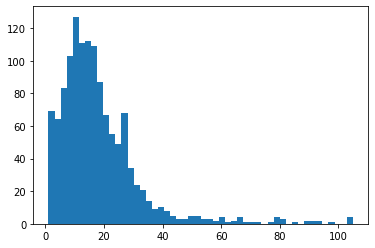

In [21]:
# The distribution of test data sentences length is right skewed
plt.hist([len(s) for s in test_sentences], bins=50)
plt.show()

In [22]:
# Since the max length of test sentences is larger than max length of train sentences,
# I calculate how many test sentences would be covered without cutting extra length.
# The result shows that it covers about 94% of the test data.
test_tokens = [len(s) for s in test_sentences]
test_tokens = np.array(test_tokens)
np.sum(test_tokens < maxlen) / len(test_tokens)

0.9448329448329449

## 2. Entity Recognization Models

### 2.1 Simple Library

In [23]:
def recog_lib(sent):
    with open('train.txt', 'r', encoding='utf-8') as f:
        train = f.readlines()
    train = [w.strip().split() for w in train]
    
    train = pd.DataFrame(train)
    train.columns = ["word", "tag"]
    train["tag"][train["tag"] == 'B-person'] = "person"
    train["tag"][train["tag"] == 'I-person'] = "person"
    train["tag"][train["tag"] == 'B-group'] = "group"
    train["tag"][train["tag"] == 'I-group'] = "group"
    train["tag"][train["tag"] == 'B-location'] = "location"
    train["tag"][train["tag"] == 'I-location'] = "location"
    train["tag"][train["tag"] == 'B-corporation'] = "corporation"
    train["tag"][train["tag"] == 'I-corporation'] = "corporation"
    train["tag"][train["tag"] == 'B-product'] = "product"
    train["tag"][train["tag"] == 'I-product'] = "product"
    train["tag"][train["tag"] == 'B-creative-work'] = "creative-work"
    train["tag"][train["tag"] == 'I-creative-work'] = "creative-work"
    
    #create a entity dictionary from train data
    tags = set(train.tag)
    d = dict()
    for t in tags:
        d[t] = list(train["word"][train.tag == t])
     
    #identify entities in test sentences 
    person = []
    group = []
    location = []
    corporation = []
    product = []
    creative_work = []
    
    for w in sent:
        if w in d["person"]:
            person.append(w)
        elif w in d["group"]:
            group.append(w)
        elif w in d["location"]:
            location.append(w)
        elif w in d["corporation"]:
            corporation.append(w)
        elif w in d["product"]:
            product.append(w)
        elif w in d["creative-work"]:
            creative_work.append(w)
    
    #sort results
    ents = dict()
    if person != []:
        ents["person"] = person 
    if group != []:
        ents["group"] = group 
    if location != []:
        ents["location"] = location 
    if corporation != []:
        ents["corporation"] = corporation
    if product != []:
        ents["product"] = product 
    if creative_work != []:
        ents["creative-work"] = creative_work 
    
    return ents


In [24]:
# test with train data
# Entity recognization with simple library would result in redundant recognization
for i in range(1, 50):
    train_string = [w[0] for w in train_sentences[i]]
    train_string_sent = " ".join(train_string)
    train_ents = [(w[0], w[1]) for w in train_sentences[i] if w[1] != "O"]
    train_pred = recog_lib(train_string)
    
    print("Predicted text: ", train_string_sent)
    print("text entities: ", train_ents)
    print("predicted entities: ", train_pred)

Predicted text:  From Green Newsfeed : AHFA extends deadline for Sage Award to Nov . 5 http://tinyurl.com/24agj38
text entities:  [('AHFA', 'B-group')]
predicted entities:  {'person': ['.'], 'group': ['Green', 'AHFA', '5'], 'product': [':', 'to']}
Predicted text:  Pxleyes Top 50 Photography Contest Pictures of August 2010 ... http://bit.ly/bgCyZ0 #photography
text entities:  [('Pxleyes', 'B-corporation')]
predicted entities:  {'person': ['50', 'of', 'August'], 'corporation': ['Pxleyes']}
Predicted text:  today is my last day at the office .
text entities:  []
predicted entities:  {'person': ['the', '.'], 'group': ['day'], 'product': ['office']}
Predicted text:  4Dbling 's place til monday , party party party . &lt; 3
text entities:  [('4Dbling', 'B-person')]
predicted entities:  {'person': ['4Dbling', '.'], 'group': [','], 'location': ["'s"], 'creative-work': ['3']}
Predicted text:  watching the VMA pre-show again lol it was n't even a good show the first time ... so bored !
text entit

Predicted text:  Really hope I can get to @glasgowfilm for Winter 's Bone - need to get on with job applications tonight then ! Trailer : http://bit.ly/bhUlum
text entities:  [('Winter', 'B-creative-work'), ("'s", 'I-creative-work'), ('Bone', 'I-creative-work')]
predicted entities:  {'group': ['I'], 'location': ["'s"], 'product': ['to', 'to', 'with', ':'], 'creative-work': ['Winter', 'Bone']}
Predicted text:  RT @WeSpazForJB : http://twitpic.com/2nn4ee &lt; ---- still the funniest photo . of all time . ALL TIME .
text entities:  []
predicted entities:  {'person': ['the', '.', 'of', '.', '.'], 'product': [':']}
Predicted text:  I have eaten a large quantity of oranges this week ...
text entities:  []
predicted entities:  {'person': ['of'], 'group': ['I'], 'creative-work': ['a']}
Predicted text:  Bonfire tonite . All are welcome , joe included
text entities:  [('joe', 'B-person')]
predicted entities:  {'person': ['.', 'joe'], 'group': [','], 'creative-work': ['All']}
Predicted text:  @KF

In [25]:
# test with test data
# results show redundant recognization
for i in range(1, 50):
    test_string = test_sentences[i]
    test_string_sent = " ".join(test_string)
    test_string_ents = recog_lib(test_string)
    print("Predicted text: ", test_string_sent)
    print("entities:", test_string_ents)

Predicted text:  & gt ; * Police last week evacuated 80 villagers from Waltengoo Nar where dozens were killed after a series of avalanches hit the area in 2005 in the south of the territory .
entities: {'person': ['of', 'the', 'the', 'of', 'the', '.'], 'product': ['after'], 'creative-work': ['from', 'a', 'in', 'in']}
Predicted text:  & gt ; * The army on Thursday recovered the bodies of ten of its men who were killed in an avalanche the previous day .
entities: {'person': ['The', 'the', 'of', 'of', 'the', '.'], 'group': ['day'], 'creative-work': ['in']}
Predicted text:  & gt ; * The four civilians killed included two children of a family whose house was hit by a separate avalanche , also on Wednesday , a police spokesman said .
entities: {'person': ['The', 'of', '.'], 'group': ['family', ',', ','], 'location': ['house'], 'creative-work': ['a', 'a', 'a']}
Predicted text:  The bodies of the soldiers were recovered after the concerted efforts of the Avalanche Rescue Teams ( ART ) , which 

entities: {'person': ['Trump', 'the'], 'group': [','], 'corporation': ["'", "'", 's'], 'product': ['/', '/', ':'], 'creative-work': ['a', 'in', 'a']}
Predicted text:  It ' s been a hit out in the world since Fragrant posted it here , Daily Edge Sid a piece too even - https://www.reddit.com/r/ireland/comments/5m6bs8/kerrygolds_african_tv_ads_are_a_little_bit_uhh/
entities: {'person': ['the'], 'group': [','], 'location': ['world'], 'corporation': ["'", 's', 'Daily'], 'creative-work': ['a', 'in', 'it', 'a']}
Predicted text:  Guy sounds like a Grade A Douche
entities: {'person': ['A'], 'creative-work': ['Guy', 'a']}
Predicted text:  Biased , but I think the best part of this is that a MetaCanadian has the top comment .
entities: {'person': ['the', 'of', 'the', '.'], 'group': [',', 'I'], 'creative-work': ['a']}
Predicted text:  https://www.reddit.com/r/soccer/comments/5nhf8x/walter_smithmessi_was_right_we_did_play/dcbjevx/?context=3onthecontrarytrueMadridistasloveme.😢CryMessifanboy
entities

### 2.2 BiLSTM-CRF 

In [26]:
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [27]:
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in train_sentences]
X = np.array(pad_sequences(sequences=X, maxlen=maxlen, padding='post', value=n_words-1))

Using TensorFlow backend.


In [28]:
y = [[tag2idx[w[1]] for w in s] for s in train_sentences]
y = np.array(pad_sequences(maxlen=maxlen, sequences=y, padding="post", value=tag2idx["O"]))

In [29]:
pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to c:\users\licor\appdata\local\temp\pip-req-build-cuzmv7a0
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp37-none-any.whl size=101658 sha256=3949fec41ed06694dbffc0067170283c9047ae9ddd693c9eb6898b3aaae56326
  Stored in directory: C:\Users\licor\AppData\Local\Temp\pip-ephem-wheel-cache-fi861ff5\wheels\11\27\c8\4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib
Note: you may need to restart the kernel to use updated packages.


  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git 'C:\Users\licor\AppData\Local\Temp\pip-req-build-cuzmv7a0'


In [30]:
from keras.models import Model, Input, Sequential
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers.crf import CRF
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [31]:
EMBEDDING_OUT_DIM = 200
model = Sequential()
model.add(Embedding(input_dim=n_words, output_dim=EMBEDDING_OUT_DIM, input_length=maxlen))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(units=128, return_sequences=True, recurrent_dropout=0.5)))
model.add(TimeDistributed(Dense(n_tags)))
crf_layer = CRF(n_tags, sparse_target=True)
model.add(crf_layer)

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 41, 200)           2975800   
_________________________________________________________________
dropout_1 (Dropout)          (None, 41, 200)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 41, 256)           336896    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 41, 13)            3341      
_________________________________________________________________
crf_1 (CRF)                  (None, 41, 13)            377       
Total params: 3,316,414
Trainable params: 3,316,414
Non-trainable params: 0
_________________________________________________________________


In [33]:
model.compile(optimizer='adam', loss=crf_layer.loss_function, metrics=[crf_layer.accuracy])

C:\Users\licor\AppData\Local\Continuum\anaconda3\lib\site-packages\keras_contrib\layers\crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
C:\Users\licor\AppData\Local\Continuum\anaconda3\lib\site-packages\keras_contrib\layers\crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


In [34]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history = model.fit(X, y.reshape(y.shape[0], y.shape[1], 1), 
                    callbacks=[es], batch_size=32, epochs=50, validation_split=0.2, verbose=1)

C:\Users\licor\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2716 samples, validate on 679 samples
Epoch 1/50
2716/2716 [==============================] - 11s 4ms/step - loss: 0.4662 - crf_viterbi_accuracy: 0.8925 - val_loss: 0.1452 - val_crf_viterbi_accuracy: 0.9768
Epoch 2/50
2716/2716 [==============================] - 10s 4ms/step - loss: 0.1295 - crf_viterbi_accuracy: 0.9776 - val_loss: 0.1318 - val_crf_viterbi_accuracy: 0.9768
Epoch 3/50
2716/2716 [==============================] - 10s 4ms/step - loss: 0.1043 - crf_viterbi_accuracy: 0.9777 - val_loss: 0.1198 - val_crf_viterbi_accuracy: 0.9768
Epoch 4/50
2716/2716 [==============================] - 10s 4ms/step - loss: 0.0783 - crf_viterbi_accuracy: 0.9779 - val_loss: 0.1143 - val_crf_viterbi_accuracy: 0.9768
Epoch 5/50
2716/2716 [==============================] - 10s 4ms/step - loss: 0.0582 - crf_viterbi_accuracy: 0.9791 - val_loss: 0.1143 - val_crf_viterbi_accuracy: 0.9764
Epoch 00005: early stopping


In [35]:
class predict_bilstm_crf:
    def __init__(self, model, words, word2idx, tags, n_words, maxlen):
        self.model = model
        self.words = words
        self.word2idx = word2idx
        self.tags = tags
        self.n_words = n_words
        self.maxlen = maxlen
        
    def predict(self, sent_lis):
        sent = " ".join(sent_lis) #return horitonal line to facilitate observation
        ents = []
        tokens = [[self.word2idx[word] for word in sent.split() if word in self.words]]
        padded = pad_sequences(tokens, maxlen=self.maxlen, padding='post', value=self.n_words-1)
        pred_ner = np.argmax(self.model.predict(padded), axis=-1)
        for w,pred in zip(padded[0], pred_ner[0]):
            if w == self.n_words - 1:
                break
            elif self.tags[pred] != 'O':
                ents.append((self.words[w], self.tags[pred]))
        return sent, ents
    
    def ent_sort(self, sent_lis):
        sent, ents = self.predict(sent_lis)
        
        person = []
        group = []
        location = []
        corporation = []
        product = []
        creative_work = []
        for i in ents:
            if i[1] == 'B-person' or i[1] == 'I-person':
                person.append(i[0])
            elif i[1] == 'B-group' or i[1] == 'I-group':
                group.append(i[0])
            elif i[1] == 'B-location' or i[1] == 'I-location':
                location.append(i[0])
            elif i[1] == 'B-corporation' or i[1] == 'I-corporation':
                corporation.append(i[0])
            elif i[1] == 'B-product' or i[1] == 'I-product':
                product.append(i[0])
            elif i[1] == 'B-creative-work' or i[1] == 'I-creative-work':
                creative_work.append(i[0])
        
        ents_dict = dict()
        if person != []:
            ents_dict["person"] = person 
        if group != []:
            ents_dict["group"] = group 
        if location != []:
            ents_dict["location"] = location 
        if corporation != []:
            ents_dict["corporation"] = corporation
        if product != []:
            ents_dict["product"] = product 
        if creative_work != []:
            ents_dict["creative-work"] = creative_work
            
        return sent, ents_dict

In [36]:
my_ent_init = predict_bilstm_crf(model, word2idx=word2idx, words=words, tags=tags, n_words=n_words, maxlen=maxlen)

In [37]:
# test with train data
# Most entities can be identified, but in wrong category.
# Model tends to wrongly classify entites to person/location 
for i in range(0, 50):
    train_sent_lis = [w[0] for w in train_sentences[i]]
    train_ents = [(w[0], w[1]) for w in train_sentences[i] if w[1] != "O"]
    train_sent, train_pred = my_ent_init.ent_sort(train_sent_lis)
    
    print("Predicted text: ", train_sent)
    print("text entities: ", train_ents)
    print("predicted entities: ", train_pred)

Predicted text:  @paulwalk It 's the view from where I 'm living for two weeks . Empire State Building = ESB . Pretty bad storm here last evening .
text entities:  [('Empire', 'B-location'), ('State', 'I-location'), ('Building', 'I-location'), ('ESB', 'B-location')]
predicted entities:  {'person': ['Empire', 'State', 'Building', 'ESB']}
Predicted text:  From Green Newsfeed : AHFA extends deadline for Sage Award to Nov . 5 http://tinyurl.com/24agj38
text entities:  [('AHFA', 'B-group')]
predicted entities:  {'person': ['AHFA']}
Predicted text:  Pxleyes Top 50 Photography Contest Pictures of August 2010 ... http://bit.ly/bgCyZ0 #photography
text entities:  [('Pxleyes', 'B-corporation')]
predicted entities:  {}
Predicted text:  today is my last day at the office .
text entities:  []
predicted entities:  {}
Predicted text:  4Dbling 's place til monday , party party party . &lt; 3
text entities:  [('4Dbling', 'B-person')]
predicted entities:  {}
Predicted text:  watching the VMA pre-show ag

In [38]:
# test with test data
# The test prediction results also show that this model can identify entites with wrong category
for i in range(0, 200):
    test_sent_lis = test_sentences[i]
    test_sent, test_ents = my_ent_init.ent_sort(test_sent_lis)
    print("Predicted text: ", test_sent)
    print("entities:", test_ents)

Predicted text:  & gt ; * The soldier was killed when another avalanche hit an army barracks in the northern area of Sonmarg , said a military spokesman .
entities: {}
Predicted text:  & gt ; * Police last week evacuated 80 villagers from Waltengoo Nar where dozens were killed after a series of avalanches hit the area in 2005 in the south of the territory .
entities: {}
Predicted text:  & gt ; * The army on Thursday recovered the bodies of ten of its men who were killed in an avalanche the previous day .
entities: {}
Predicted text:  & gt ; * The four civilians killed included two children of a family whose house was hit by a separate avalanche , also on Wednesday , a police spokesman said .
entities: {}
Predicted text:  The bodies of the soldiers were recovered after the concerted efforts of the Avalanche Rescue Teams ( ART ) , which is equipped to work in inhospitable terrain and weather conditions .
entities: {}
Predicted text:  & gt ; * Arrangements are in place to carry the mortal

Predicted text:  Wow , / r / news totally kicked the shit out of / r / politics on this topic .
entities: {}
Predicted text:  Love Lynda .
entities: {}
Predicted text:  Here ' s a link to a Redditor ' s experience in Calgary :
entities: {}
Predicted text:  [ OP of the previous threads could n ' t handle the Ronaldo criticism .
entities: {}
Predicted text:  You ' re speaking from a Brit ' s point of view .
entities: {}
Predicted text:  * * redditor * * : Quickloot
entities: {}
Predicted text:  * * submission title * * : Battle underway for return of Napoleon ' s horse Marengo to Ireland
entities: {}
Predicted text:  [ Yo .
entities: {}
Predicted text:  * * submission title * * : Does anyone know if anyone has started protesting at CVG yet ?
entities: {}
Predicted text:  Reddit ' s tough guys say yes .
entities: {}
Predicted text:  Media pounces on it .
entities: {}
Predicted text:  they changed all the topics to Zlatan .
entities: {}
Predicted text:  The mods deleted [ this story about 

Predicted text:  [ Warum das eine absolut beschissene Idee ist .
entities: {}
Predicted text:  ( personally , I think Rastus is his jilted lover . . . ; )
entities: {}
Predicted text:  Edit : [ Context in case anyone was wondering ] ( https://www.reddit.com/r/soccer/comments/5pwos9/slug/dcuerzp )
entities: {}
Predicted text:  Yet in [ another post ] ( https://www.reddit.com/r/australia/comments/5m9hs3/labors_linda_burney_requests_auditorgeneral/dc2atzg/ ) you lambast Labor for * * only * * three of their front bench publicly denouncing this debacle .
entities: {}
Predicted text:  [ Aaaaaand there it is ] ( https://www.reddit.com/r/newzealand/comments/5zhb0d/auckland_university_has_introduced_allgender/deydfz7/?utm_content=permalink&amp;utm_medium=front&amp;utm_source=reddit&amp;utm_name=newzealand )
entities: {}
Predicted text:  BuzzFeed took the bait .
entities: {}
Predicted text:  / r / canada used to say the CBC went clickbait because those evil cons tried to defund them , but the r

### 2.3 Perceptron Classifier

In [39]:
import sklearn
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import Perceptron
from sklearn.metrics import precision_recall_fscore_support, f1_score

In [40]:
postag = []
for i in range(0, len(train_sentences)):
    postag.append([p[1] for p in pos_tag([w[0] for w in train_sentences[i]])] )   

In [41]:
# unnest list and combine to dataframe
from itertools import chain
train_df["pos"] = list(chain.from_iterable(postag))
train_df

,word,tag,pos
0,@paulwalk,O,VB
1,It,O,PRP
2,'s,O,VBZ
3,the,O,DT
4,view,O,NN
...,...,...,...
66118,39,O,CD
66119,GMT+0000,O,NNP
66120,(,O,(
66121,UTC,O,NNP


In [42]:
x = train_df.drop(['tag'], axis=1)
vectorizer = DictVectorizer(sparse=False)
X = vectorizer.fit_transform(x.to_dict("records"))
X.shape

(62730, 14920)

In [43]:
y = train_df.tag.values
y.shape

(62730,)

In [44]:
tag_class = np.unique(y).tolist()

In [45]:
per = Perceptron(verbose=10, n_jobs=-1, max_iter=5)
per.partial_fit(X, y, tag_class)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


-- Epoch 1-- Epoch 1

-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1-- Epoch 1

-- Epoch 1
Norm: 20.74, NNZs: 297, Bias: -2.000000, T: 62730, Avg. loss: 0.004910
Total training time: 2.31 seconds.
-- Epoch 1
Norm: 17.78, NNZs: 246, Bias: -3.000000, T: 62730, Avg. loss: 0.004033
Total training time: 2.34 seconds.
Norm: 14.97, NNZs: 203, Bias: -2.000000, T: 62730, Avg. loss: 0.004926
Total training time: 2.35 seconds.
-- Epoch 1-- Epoch 1

Norm: 9.17, NNZs: 78, Bias: -3.000000, T: 62730, Avg. loss: 0.001530
Total training time: 2.35 seconds.
Norm: 23.19, NNZs: 431, Bias: -2.000000, T: 62730, Avg. loss: 0.008210
-- Epoch 1Total training time: 2.38 seconds.

-- Epoch 1
Norm: 33.73, NNZs: 817, Bias: -3.000000, T: 62730, Avg. loss: 0.015272
Total training time: 2.39 seconds.
Norm: 36.66, NNZs: 999, Bias: -3.000000, T: 62730, Avg. loss: 0.017360
Total training time: 2.39 seconds.
Norm: 17.20, NNZs: 250, Bias: -4.000000, T: 62730, Avg. loss: 0.007413
Total training time: 2.38 seconds.


[Parallel(n_jobs=-1)]: Done   2 out of  13 | elapsed:    2.3s remaining:   12.9s
[Parallel(n_jobs=-1)]: Done   4 out of  13 | elapsed:    2.3s remaining:    5.3s
[Parallel(n_jobs=-1)]: Done   6 out of  13 | elapsed:    2.3s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done   8 out of  13 | elapsed:    2.3s remaining:    1.4s


Norm: 16.00, NNZs: 215, Bias: -2.000000, T: 62730, Avg. loss: 0.005149
Total training time: 1.67 seconds.
Norm: 19.54, NNZs: 304, Bias: -2.000000, T: 62730, Avg. loss: 0.006536
Total training time: 1.64 seconds.
Norm: 21.68, NNZs: 370, Bias: -2.000000, T: 62730, Avg. loss: 0.007604
Total training time: 1.66 seconds.
Norm: 25.61, NNZs: 502, Bias: -2.000000, T: 62730, Avg. loss: 0.009660
Total training time: 1.67 seconds.
Norm: 73.08, NNZs: 3536, Bias: 3.000000, T: 62730, Avg. loss: 0.076136
Total training time: 1.71 seconds.


[Parallel(n_jobs=-1)]: Done  10 out of  13 | elapsed:    3.9s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    4.0s finished


Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=5, n_iter_no_change=5, n_jobs=-1,
           penalty=None, random_state=0, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=10, warm_start=False)

In [46]:
# accuracy with train data
print(sklearn.metrics.classification_report(y_pred = per.predict(X), y_true = y, labels = tag_class))

C:\Users\licor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                 precision    recall  f1-score   support

  B-corporation       0.61      0.70      0.65       221
B-creative-work       0.80      0.09      0.15       140
        B-group       0.74      0.62      0.67       264
     B-location       0.87      0.31      0.45       548
       B-person       0.88      0.30      0.45       660
      B-product       0.94      0.23      0.36       142
  I-corporation       0.00      0.00      0.00        46
I-creative-work       0.00      0.00      0.00       206
        I-group       0.83      0.10      0.18       150
     I-location       0.84      0.18      0.29       245
       I-person       0.85      0.73      0.78       335
      I-product       0.90      0.13      0.22       203
              O       0.97      1.00      0.98     59570

       accuracy                           0.96     62730
      macro avg       0.71      0.34      0.40     62730
   weighted avg       0.96      0.96      0.96     62730



In [47]:
class model_test_data:
    def __init__(self, model):
        self.model = model
        
    def predict(self, sent_lis):
        sent = " ".join(sent_lis) #return horitonal line to facilitate observation
        ents = []
        sent_df = pd.DataFrame(pos_tag(sent_lis))
        sent_df.columns = ["word", "pos"]
        sent_df = sent_df[sent_df['word'].notnull()]
        sent_vec = vectorizer.transform(sent_df.to_dict("records"))
        pred_ner = self.model.predict(sent_vec)
        for i in range(0, len(pred_ner)):
            if pred_ner[i] != 'O':
                ents.append((sent_lis[i], pred_ner[i]))
        return sent, ents
    
    def ent_sort(self, sent_lis):
        sent, ents = self.predict(sent_lis)
        
        person = []
        group = []
        location = []
        corporation = []
        product = []
        creative_work = []
        for i in ents:
            if i[1] == 'B-person' or i[1] == 'I-person':
                person.append(i[0])
            elif i[1] == 'B-group' or i[1] == 'I-group':
                group.append(i[0])
            elif i[1] == 'B-location' or i[1] == 'I-location':
                location.append(i[0])
            elif i[1] == 'B-corporation' or i[1] == 'I-corporation':
                corporation.append(i[0])
            elif i[1] == 'B-product' or i[1] == 'I-product':
                product.append(i[0])
            elif i[1] == 'B-creative-work' or i[1] == 'I-creative-work':
                creative_work.append(i[0])
        
        ents_dict = dict()
        if person != []:
            ents_dict["person"] = person 
        if group != []:
            ents_dict["group"] = group 
        if location != []:
            ents_dict["location"] = location 
        if corporation != []:
            ents_dict["corporation"] = corporation
        if product != []:
            ents_dict["product"] = product 
        if creative_work != []:
            ents_dict["creative-work"] = creative_work
            
        return sent, ents_dict

In [48]:
my_per_init = model_test_data(per)

In [49]:
# test with train data
# This method would miss entities

for i in range(0, 50):
    train_sent_lis = [w[0] for w in train_sentences[i]]
    train_ents = [(w[0], w[1]) for w in train_sentences[i] if w[1] != "O"]
    train_sent, train_pred = my_per_init.ent_sort(train_sent_lis)
    
    print("Predicted text: ", train_sent)
    print("text entities: ", train_ents)
    print("predicted entities: ", train_pred)

Predicted text:  @paulwalk It 's the view from where I 'm living for two weeks . Empire State Building = ESB . Pretty bad storm here last evening .
text entities:  [('Empire', 'B-location'), ('State', 'I-location'), ('Building', 'I-location'), ('ESB', 'B-location')]
predicted entities:  {'group': ['State'], 'location': ['Empire', 'Building', 'ESB']}
Predicted text:  From Green Newsfeed : AHFA extends deadline for Sage Award to Nov . 5 http://tinyurl.com/24agj38
text entities:  [('AHFA', 'B-group')]
predicted entities:  {'group': ['AHFA']}
Predicted text:  Pxleyes Top 50 Photography Contest Pictures of August 2010 ... http://bit.ly/bgCyZ0 #photography
text entities:  [('Pxleyes', 'B-corporation')]
predicted entities:  {}
Predicted text:  today is my last day at the office .
text entities:  []
predicted entities:  {}
Predicted text:  4Dbling 's place til monday , party party party . &lt; 3
text entities:  [('4Dbling', 'B-person')]
predicted entities:  {}
Predicted text:  watching the VMA

In [50]:
# test with test data
# The test prediction results also show that this model will miss entites
for i in range(0, 200):
    test_sent_lis = test_sentences[i]
    test_sent, test_ents = my_per_init.ent_sort(test_sent_lis)
    print("Predicted text: ", test_sent)
    print("entities:", test_ents)

Predicted text:  & gt ; * The soldier was killed when another avalanche hit an army barracks in the northern area of Sonmarg , said a military spokesman .
entities: {}
Predicted text:  & gt ; * Police last week evacuated 80 villagers from Waltengoo Nar where dozens were killed after a series of avalanches hit the area in 2005 in the south of the territory .
entities: {}
Predicted text:  & gt ; * The army on Thursday recovered the bodies of ten of its men who were killed in an avalanche the previous day .
entities: {}
Predicted text:  & gt ; * The four civilians killed included two children of a family whose house was hit by a separate avalanche , also on Wednesday , a police spokesman said .
entities: {}
Predicted text:  The bodies of the soldiers were recovered after the concerted efforts of the Avalanche Rescue Teams ( ART ) , which is equipped to work in inhospitable terrain and weather conditions .
entities: {}
Predicted text:  & gt ; * Arrangements are in place to carry the mortal

Predicted text:  Where ' s the one from ~ ~ Syria ~ ~ Serbia where some guy banged it over the bar from the goalline ?
entities: {}
Predicted text:  Hey Tom , can you comment on this thread ?
entities: {}
Predicted text:  & gt ; you cannot infer much from a single quarter ' s GDP statistics .
entities: {}
Predicted text:  True , but I imagine it would be a lot lower and as I pointed out to Andrew Little would be cheaper than [ eliminating fees .
entities: {}
Predicted text:  She ' s been making me question my sexuality since The X-Files started .
entities: {}
Predicted text:  * * submission title * * : PSG tell Inter & amp ; Juve Verratti will cost € 100 M
entities: {'person': ['M']}
Predicted text:  Not sure if trust Donald on this .
entities: {}
Predicted text:  EDIT : No actually screw that , i ' d like to ask why you ' d want attacks on Trump supporters to continue ?
entities: {}
Predicted text:  Perhaps this paper instead actually suggests that students born in July are underdiagn

Predicted text:  On Reddit , I do n ' t think people care as much as they think they do regarding minorities .
entities: {}
Predicted text:  It came into effect on the 30 th of December 2016 .
entities: {}


### 2.4 SGDClassifier

In [51]:
from sklearn.linear_model import SGDClassifier

In [52]:
sgd = SGDClassifier()

sgd.partial_fit(X, y, tag_class)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [53]:
# accuracy with train data
# less balanced correct rate than Perceptron Classifier
print(sklearn.metrics.classification_report(y_pred = sgd.predict(X), y_true = y, labels = tag_class))

C:\Users\licor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                 precision    recall  f1-score   support

  B-corporation       1.00      0.24      0.39       221
B-creative-work       0.00      0.00      0.00       140
        B-group       0.00      0.00      0.00       264
     B-location       0.92      0.04      0.08       548
       B-person       0.94      0.09      0.16       660
      B-product       0.00      0.00      0.00       142
  I-corporation       0.00      0.00      0.00        46
I-creative-work       0.00      0.00      0.00       206
        I-group       0.00      0.00      0.00       150
     I-location       0.00      0.00      0.00       245
       I-person       0.89      0.07      0.13       335
      I-product       0.00      0.00      0.00       203
              O       0.95      1.00      0.98     59570

       accuracy                           0.95     62730
      macro avg       0.36      0.11      0.13     62730
   weighted avg       0.93      0.95      0.93     62730



In [54]:
my_sgd_init = model_test_data(sgd)

In [55]:
# test with train data
# This method would miss more entities than Perceptron Classifier

for i in range(0, 50):
    train_sent_lis = [w[0] for w in train_sentences[i]]
    train_ents = [(w[0], w[1]) for w in train_sentences[i] if w[1] != "O"]
    train_sent, train_pred = my_sgd_init.ent_sort(train_sent_lis)
    
    print("Predicted text: ", train_sent)
    print("text entities: ", train_ents)
    print("predicted entities: ", train_pred)

Predicted text:  @paulwalk It 's the view from where I 'm living for two weeks . Empire State Building = ESB . Pretty bad storm here last evening .
text entities:  [('Empire', 'B-location'), ('State', 'I-location'), ('Building', 'I-location'), ('ESB', 'B-location')]
predicted entities:  {}
Predicted text:  From Green Newsfeed : AHFA extends deadline for Sage Award to Nov . 5 http://tinyurl.com/24agj38
text entities:  [('AHFA', 'B-group')]
predicted entities:  {}
Predicted text:  Pxleyes Top 50 Photography Contest Pictures of August 2010 ... http://bit.ly/bgCyZ0 #photography
text entities:  [('Pxleyes', 'B-corporation')]
predicted entities:  {}
Predicted text:  today is my last day at the office .
text entities:  []
predicted entities:  {}
Predicted text:  4Dbling 's place til monday , party party party . &lt; 3
text entities:  [('4Dbling', 'B-person')]
predicted entities:  {}
Predicted text:  watching the VMA pre-show again lol it was n't even a good show the first time ... so bored !


In [56]:
# test with test data
# The test prediction results also show that this model has deteriorated performance
for i in range(0, 200):
    test_sent_lis = test_sentences[i]
    test_sent, test_ents = my_sgd_init.ent_sort(test_sent_lis)
    print("Predicted text: ", test_sent)
    print("entities:", test_ents)

Predicted text:  & gt ; * The soldier was killed when another avalanche hit an army barracks in the northern area of Sonmarg , said a military spokesman .
entities: {}
Predicted text:  & gt ; * Police last week evacuated 80 villagers from Waltengoo Nar where dozens were killed after a series of avalanches hit the area in 2005 in the south of the territory .
entities: {}
Predicted text:  & gt ; * The army on Thursday recovered the bodies of ten of its men who were killed in an avalanche the previous day .
entities: {}
Predicted text:  & gt ; * The four civilians killed included two children of a family whose house was hit by a separate avalanche , also on Wednesday , a police spokesman said .
entities: {}
Predicted text:  The bodies of the soldiers were recovered after the concerted efforts of the Avalanche Rescue Teams ( ART ) , which is equipped to work in inhospitable terrain and weather conditions .
entities: {}
Predicted text:  & gt ; * Arrangements are in place to carry the mortal

Predicted text:  The mods deleted [ this story about activists being beaten by Trump supporters ] ( https://m.reddit.com/r/politics/comments/5m3r1c/activists_brutally_attacked_by_donald_trump/ ) for being off topic .
entities: {}
Predicted text:  Yeah , and they get all misty-eyed about government-owned businesses and how awful it is that Costello sold them off etc , only because they ' re not old enough to remember having to deal with government-owned businesses and how fucking useless they are :
entities: {}
Predicted text:  Step 2 : [ Google ] ( http://www.google.co.nz )
entities: {}
Predicted text:  Lol this is what city pussis think of living outside a major city is like
entities: {}
Predicted text:  You could try and send an email to the teams and see what they reply : D
entities: {}
Predicted text:  Resultat . dk
entities: {}
Predicted text:  * * Edit : * * Wow , that blew up .
entities: {}
Predicted text:  I asked Bellerin v walker in a match thread a few months ago , the resul

Predicted text:  / r / canada used to say the CBC went clickbait because those evil cons tried to defund them , but the rut is clearly much deeper and more permanent .
entities: {}
Predicted text:  * * comment content * * : Marseille has .
entities: {}
Predicted text:  Original post : [ ' Many wounded ' in Istanbul nightclub attack ] ( https://www.reddit.com/r/worldnews/comments/5lcaed/many_wounded_in_istanbul_nightclub_attack/ )
entities: {}
Predicted text:  It ' s got the GIFs of the goals .
entities: {}
Predicted text:  Velvet has such a thin skin he actually deleted and resubmitted an article because someone disagreed with him :
entities: {}
Predicted text:  Hector was holding back I assume playing it safe with injuries / fitness .
entities: {}
Predicted text:  Exatamente .
entities: {}
Predicted text:  Narsingh to see here , [ r / soccer thread ] ( https://www.reddit.com/r/soccer/comments/5ne3ed/psv_right_winger_luciano_narsingh_set_to_move_to/ ) totally brutal
entities: {}
Predic